In [44]:
from pathlib import Path
import numpy as np
from snirf import Snirf
import mne
from mne_nirs.io import write_raw_snirf
from snirf import validateSnirf
import os
import snirf
from mne.io import read_raw_nirx, read_raw_snirf
from mne.preprocessing.nirs import beer_lambert_law, optical_density
from numpy.testing import assert_allclose
from pathlib import Path

In [73]:
# homer3_to_mne_compatible.py
#
#
# - Take Homer3 HbO/HbR/HbT SNIRF
# - Drop HbT channels
# - Keep measurementList as a proper pysnirf2 IndexedGroup
# - Save a new SNIRF that mne.io.read_raw_snirf can read as hbo/hbr


# ------------------------------------------------------------
# 1) INPUT / OUTPUT PATHS  -----------------------------------
# ------------------------------------------------------------
in_fname = Path(
    '/Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/snirf_files_with_correct_stim_events_BNDY/preproc_for_mne/sub-bndy_ses-tp1_task-arith_run-4_nirs_with_events_preproc_hb.snirf'
)

out_fname = in_fname.with_name(in_fname.stem + "_mne.snirf")

print(f"Input SNIRF: {in_fname}")
print(f"Will write:  {out_fname}")

# ------------------------------------------------------------
# 2) LOAD SNIRF  ---------------------------------------------
# ------------------------------------------------------------
snirf = Snirf(str(in_fname))

# Assume single nirs element and single data block (true for Homer3 export)
nirs = snirf.nirs[0]
data = nirs.data[0]
ml = data.measurementList   # IMPORTANT: this is an IndexedGroup, not a list

# ------------------------------------------------------------
# 3) INSPECT dataTypeLabel AND BUILD KEEP MASK ---------------
# ------------------------------------------------------------
labels = [str(ml[i].dataTypeLabel) for i in range(len(ml))]
uniq = sorted(set(labels))
print("Unique dataTypeLabel values BEFORE:", uniq)

keep_mask = np.array(
    [(lab == "HbO") or (lab == "HbR") for lab in labels],
    dtype=bool,
)

n_total = len(labels)
n_keep = int(keep_mask.sum())

print(f"Total channels: {n_total}")
print(f"Keeping {n_keep} channels (HbO/HbR only)")
print(f"Dropping {n_total - n_keep} channels (e.g. HbT)")

# ------------------------------------------------------------
# 4) SLICE dataTimeSeries TO MATCH KEEP MASK -----------------
# ------------------------------------------------------------
ts = np.asarray(data.dataTimeSeries)
if ts.shape[1] != n_total:
    raise RuntimeError(
        f"dataTimeSeries has {ts.shape[1]} columns but measurementList has {n_total} entries"
    )

ts = ts[:, keep_mask]
data.dataTimeSeries = ts  # assign back (pysnirf2 accepts numpy arrays)

# ------------------------------------------------------------
# 5) DROP UNWANTED measurementList ENTRIES IN PLACE ----------
# ------------------------------------------------------------
# Do NOT do: data.measurementList = [...]
# Instead, delete entries from the existing IndexedGroup, from end to start.
for i in range(n_total - 1, -1, -1):
    if not keep_mask[i]:
        del ml[i]

# Sanity check
if len(ml) != n_keep:
    raise RuntimeError(
        f"After deletion, measurementList has {len(ml)} entries, expected {n_keep}"
    )

# ------------------------------------------------------------
# 6) SAVE NEW SNIRF  -----------------------------------------
# ------------------------------------------------------------
snirf.save(str(out_fname))
print("Done.")


Input SNIRF: /Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/snirf_files_with_correct_stim_events_BNDY/preproc_for_mne/sub-bndy_ses-tp1_task-arith_run-4_nirs_with_events_preproc_hb.snirf
Will write:  /Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/snirf_files_with_correct_stim_events_BNDY/preproc_for_mne/sub-bndy_ses-tp1_task-arith_run-4_nirs_with_events_preproc_hb_mne.snirf
Unique dataTypeLabel values BEFORE: ['HbO', 'HbR', 'HbT']
Total channels: 138
Keeping 92 channels (HbO/HbR only)
Dropping 46 channels (e.g. HbT)
Done.


In [74]:
# fix_landmarks_in_snirf.py

# 1) Path to the _mne.snirf file you just created
snirf_path = Path(str(out_fname))
print("Opening:", snirf_path)

# 2) Open file for read/write (r+)
with Snirf(str(snirf_path), "r+") as snirf:
    probe = snirf.nirs[0].probe

    print("Before:")
    print("  landmarkPos3D:", probe.landmarkPos3D)
    print("  landmarkLabels:", probe.landmarkLabels)

    # 3) Remove landmarks (let them be None / absent)
    probe.landmarkPos3D = None
    probe.landmarkLabels = None

    # 4) Save in-place
    snirf.save()

    print("After:")
    print("  landmarkPos3D:", probe.landmarkPos3D)
    print("  landmarkLabels:", probe.landmarkLabels)

print("Done cleaning landmarks.")


Opening: /Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/snirf_files_with_correct_stim_events_BNDY/preproc_for_mne/sub-bndy_ses-tp1_task-arith_run-4_nirs_with_events_preproc_hb_mne.snirf
Before:
  landmarkPos3D: []
  landmarkLabels: None
After:
  landmarkPos3D: None
  landmarkLabels: None
Done cleaning landmarks.


In [75]:
# rewrite_snirf_with_mne_fixed.py

in_fname = str(out_fname)

out_clean = str(out_fname.with_name(out_fname.stem + "_clean.snirf"))

print("Loading", in_fname)
raw = mne.io.read_raw_snirf(in_fname, preload=True)

# --- Fix NaN wavelengths in raw.info['chs'] ---
for ch in raw.info["chs"]:
    wl = ch["loc"][9]
    if not np.isfinite(wl):
        name = ch["ch_name"]
        # Simple rule: assign dummy wavelength based on chromophore
        if name.endswith(" hbo"):
            ch["loc"][9] = 760.0   # or your real lambda1
        elif name.endswith(" hbr"):
            ch["loc"][9] = 850.0   # or your real lambda2
        else:
            # Fallback: just pick one
            ch["loc"][9] = 760.0

# --- Now write SNIRF using MNE-NIRS ---
print("Writing", out_clean)
write_raw_snirf(raw, out_clean)

# --- Validate with pysnirf2 ---
print("Validating with pysnirf2...")
res = validateSnirf(out_clean)
res.display()



Loading /Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/snirf_files_with_correct_stim_events_BNDY/preproc_for_mne/sub-bndy_ses-tp1_task-arith_run-4_nirs_with_events_preproc_hb_mne.snirf
Loading /Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/snirf_files_with_correct_stim_events_BNDY/preproc_for_mne/sub-bndy_ses-tp1_task-arith_run-4_nirs_with_events_preproc_hb_mne.snirf
Found jitter of 0.000000% in sample times.
Reading 0 ... 1739  =      0.000 ...   173.900 secs...
Writing /Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/snirf_files_with_correct_stim_events_BNDY/preproc_for_mne/sub-bndy_ses-tp1_task-arith_run-4_nirs_with_events_preproc_hb_mne_clean.snirf
Validating with pysnirf2...

Found 574 OK      (hidden)
Found 753 INFO    (hidden)
Found 0 WARNING
Found 0 FATAL  

File is VALID


In [76]:
# Check if .snirf file is loading and valid

file_path = str(out_clean)

out_fname = Path(file_path)

print("Loading", out_fname)
raw_hb = mne.io.read_raw_snirf(str(out_fname), preload=True)
print(raw_hb)
print(raw_hb.get_channel_types(unique=True))

result = validateSnirf(file_path)
assert result.is_valid()
result.display()


Loading /Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/snirf_files_with_correct_stim_events_BNDY/preproc_for_mne/sub-bndy_ses-tp1_task-arith_run-4_nirs_with_events_preproc_hb_mne_clean.snirf
Loading /Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/snirf_files_with_correct_stim_events_BNDY/preproc_for_mne/sub-bndy_ses-tp1_task-arith_run-4_nirs_with_events_preproc_hb_mne_clean.snirf
Found jitter of 0.000000% in sample times.
Reading 0 ... 1739  =      0.000 ...   173.900 secs...
<RawSNIRF | sub-bndy_ses-tp1_task-arith_run-4_nirs_with_events_preproc_hb_mne_clean.snirf, 92 x 1740 (174.0 s), ~1.3 MiB, data loaded>
['hbo', 'hbr']

Found 574 OK      (hidden)
Found 753 INFO    (hidden)
Found 0 WARNING
Found 0 FATAL  

File is VALID


Loading SNIRF: /Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/snirf_files_with_correct_stim_events_BNDY/homer3_glm_out/sub-bndy_ses-tp1_task-arith_run-1_nirs_with_events_hb_preproc_mne_clean.snirf
Loading /Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/snirf_files_with_correct_stim_events_BNDY/homer3_glm_out/sub-bndy_ses-tp1_task-arith_run-1_nirs_with_events_hb_preproc_mne_clean.snirf
Found jitter of 0.000000% in sample times.
Reading 0 ... 1739  =      0.000 ...   173.900 secs...
<RawSNIRF | sub-bndy_ses-tp1_task-arith_run-1_nirs_with_events_hb_preproc_mne_clean.snirf, 92 x 1740 (174.0 s), ~1.3 MiB, data loaded>
Channel types: ['hbo', 'hbr']
Onset:  [ 23.049465  69.025444 115.034848]
Duration:  [36. 36. 36.]
Description:  ['arith' 'arith1' 'control']
Detected haemoglobin data → using as-is
Remaining channels: 88
Design matrix columns: ['arith', 'arith1', 'cont

/var/folders/57/27nbkr8d6tjbj5ht598xbyzm0000gn/T/ipykernel_38545/3179982135.py:83: DeprecationWarning: The parameter "ax" will be removed in 0.13.0 release of Nilearn. Please use the parameter "axes" instead.
  plot_design_matrix(design_matrix, ax=ax)


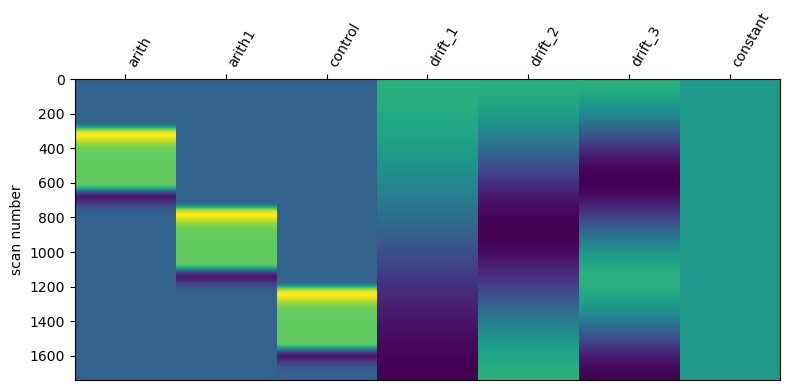

Fitting GLM...
variable Condition   df           mse   p_value        se         t     theta  \
280          arith  7.0  8.419014e-12  0.392988  0.000008  0.910182  0.000008   
281         arith1  7.0  8.419014e-12  0.128750  0.000008 -1.721955 -0.000015   
282       constant  7.0  8.419014e-12  0.502632  0.000006  0.706632  0.000004   
283        control  7.0  8.419014e-12  0.000054  0.000008 -8.668734 -0.000073   
284        drift_1  7.0  8.419014e-12  0.000487  0.000228 -6.108486 -0.001392   

variable  Source  Detector Chroma  Significant    ch_name  
280            1         1    hbo        False  S1_D1 hbo  
281            1         1    hbo        False  S1_D1 hbo  
282            1         1    hbo        False  S1_D1 hbo  
283            1         1    hbo         True  S1_D1 hbo  
284            1         1    hbo         True  S1_D1 hbo  
Saved GLM results to: /Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/snirf

In [49]:
# glm_from_snirf.py

from pathlib import Path

import mne
import pandas as pd

from mne.preprocessing.nirs import optical_density, beer_lambert_law
from mne_nirs.channels import get_long_channels
from mne_nirs.experimental_design import make_first_level_design_matrix
from mne_nirs.statistics import run_glm

# -----------------------------
# 0) INPUTS (EDIT THESE)
# -----------------------------
snirf_path = out_fname  # your valid SNIRF
out_csv1 = snirf_path.with_name(snirf_path.stem + "_glm_mne.csv")
out_csv    = Path(out_csv1)



# -----------------------------
# 1) LOAD SNIRF
# -----------------------------
print(f"Loading SNIRF: {snirf_path}")
raw = mne.io.read_raw_snirf(snirf_path, preload=True)
print(raw)  # quick sanity check
print("Channel types:", raw.get_channel_types(unique=True))
print("Onset: ", raw.annotations.onset)
print("Duration: ", raw.annotations.duration)
print("Description: ", raw.annotations.description)

# Typical block length for your task (seconds)
STIM_DUR = raw.annotations.duration[0]   # change to your actual block duration

# -----------------------------
# 2) ENSURE HAEMOGLOBIN DATA
# -----------------------------
ch_types = raw.get_channel_types(unique=True)

if "fnirs_cw_amplitude" in ch_types:
    # Case A: SNIRF still contains intensity → convert to HbO/HbR
    print("Detected intensity data → converting to HbO/HbR")
    raw_od = optical_density(raw)
    raw_haemo = beer_lambert_law(raw_od)
elif any(ct in ("hbo", "hbr") for ct in ch_types):
    # Case B: already haemoglobin (typical for your Homer3 export)
    print("Detected haemoglobin data → using as-is")
    raw_haemo = raw.copy()
else:
    raise RuntimeError(
        "Unexpected channel types. Expected 'fnirs_cw_amplitude' or 'hbo'/'hbr'."
    )

# -----------------------------
# 3) KEEP ONLY LONG CHANNELS
# -----------------------------
# Removes short-separation channels; default 1.5–4.5 cm. 
raw_haemo = get_long_channels(raw_haemo)
print("Remaining channels:", len(raw_haemo.ch_names))

# (Optional) extra filter here if you *haven't* prefiltered in Homer3.
# raw_haemo = raw_haemo.filter(0.01, 0.2, verbose=False)

# -----------------------------
# 4) DESIGN MATRIX
# -----------------------------
# Uses raw_haemo.annotations (from SNIRF stim) to build regressors.
# Each unique description becomes a regressor. 
design_matrix = make_first_level_design_matrix(
    raw_haemo,
    stim_dur=STIM_DUR,
    hrf_model="glover"    # canonical HRF, like SPM
)

print("Design matrix columns:", list(design_matrix.columns))
print(design_matrix.head())

# If you have nilearn installed, you can visualise the design:
from nilearn.plotting import plot_design_matrix
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 4))
plot_design_matrix(design_matrix, ax=ax)
fig.tight_layout()
plt.show()

# -----------------------------
# 5) RUN GLM
# -----------------------------
# Wrapper around Nilearn's GLM; default AR(1) noise model. 
print("Fitting GLM...")
glm_est = run_glm(raw_haemo, design_matrix)

# glm_est is a RegressionResults object with GLM fits for all channels. 

# -----------------------------
# 6) EXPORT RESULTS
# -----------------------------
# Converts all GLM results to a tidy DataFrame:
# one row per (channel, condition, chroma) with theta, t, p, etc. 
df = glm_est.to_dataframe()
print(df.head())

df.to_csv(out_csv, index=False)
print(f"Saved GLM results to: {out_csv}")


Loading SNIRF: /Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/snirf_files_with_correct_stim_events_BNDY/homer3_glm_out/sub-bndy_ses-tp1_task-arith_run-1_nirs_with_events_hb_preproc_mne_clean.snirf
Loading /Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/snirf_files_with_correct_stim_events_BNDY/homer3_glm_out/sub-bndy_ses-tp1_task-arith_run-1_nirs_with_events_hb_preproc_mne_clean.snirf
Found jitter of 0.000000% in sample times.
Reading 0 ... 1739  =      0.000 ...   173.900 secs...
<RawSNIRF | sub-bndy_ses-tp1_task-arith_run-1_nirs_with_events_hb_preproc_mne_clean.snirf, 92 x 1740 (174.0 s), ~1.3 MiB, data loaded>
Channel types: ['hbo', 'hbr']
Onset:  [ 23.049465  69.025444 115.034848]
Duration:  [36. 36. 36.]
Description:  ['arith' 'arith1' 'control']
Detected haemoglobin data → using as-is
Remaining channels: 88
Design matrix columns: ['arith', 'arith1', 'cont

/var/folders/57/27nbkr8d6tjbj5ht598xbyzm0000gn/T/ipykernel_38545/3179982135.py:83: DeprecationWarning: The parameter "ax" will be removed in 0.13.0 release of Nilearn. Please use the parameter "axes" instead.
  plot_design_matrix(design_matrix, ax=ax)


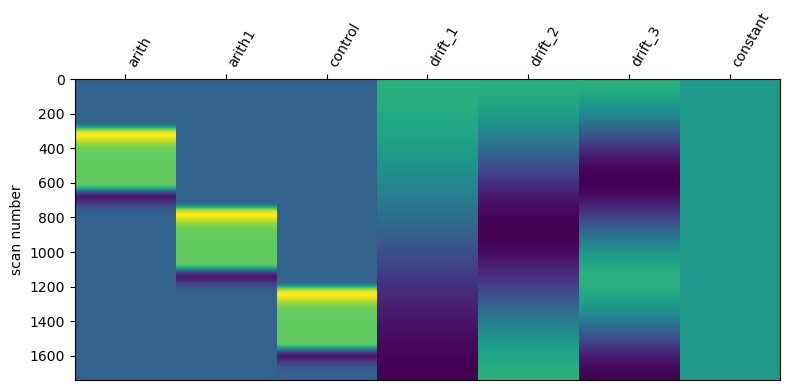

Fitting GLM...
variable Condition   df           mse   p_value        se         t     theta  \
280          arith  7.0  8.419014e-12  0.392988  0.000008  0.910182  0.000008   
281         arith1  7.0  8.419014e-12  0.128750  0.000008 -1.721955 -0.000015   
282       constant  7.0  8.419014e-12  0.502632  0.000006  0.706632  0.000004   
283        control  7.0  8.419014e-12  0.000054  0.000008 -8.668734 -0.000073   
284        drift_1  7.0  8.419014e-12  0.000487  0.000228 -6.108486 -0.001392   

variable  Source  Detector Chroma  Significant    ch_name  
280            1         1    hbo        False  S1_D1 hbo  
281            1         1    hbo        False  S1_D1 hbo  
282            1         1    hbo        False  S1_D1 hbo  
283            1         1    hbo         True  S1_D1 hbo  
284            1         1    hbo         True  S1_D1 hbo  
Saved GLM results to: /Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/snirf

In [49]:
# glm_from_snirf.py

from pathlib import Path

import mne
import pandas as pd

from mne.preprocessing.nirs import optical_density, beer_lambert_law
from mne_nirs.channels import get_long_channels
from mne_nirs.experimental_design import make_first_level_design_matrix
from mne_nirs.statistics import run_glm

# -----------------------------
# 0) INPUTS (EDIT THESE)
# -----------------------------
snirf_path = out_fname  # your valid SNIRF
out_csv1 = snirf_path.with_name(snirf_path.stem + "_glm_mne.csv")
out_csv    = Path(out_csv1)



# -----------------------------
# 1) LOAD SNIRF
# -----------------------------
print(f"Loading SNIRF: {snirf_path}")
raw = mne.io.read_raw_snirf(snirf_path, preload=True)
print(raw)  # quick sanity check
print("Channel types:", raw.get_channel_types(unique=True))
print("Onset: ", raw.annotations.onset)
print("Duration: ", raw.annotations.duration)
print("Description: ", raw.annotations.description)

# Typical block length for your task (seconds)
STIM_DUR = raw.annotations.duration[0]   # change to your actual block duration

# -----------------------------
# 2) ENSURE HAEMOGLOBIN DATA
# -----------------------------
ch_types = raw.get_channel_types(unique=True)

if "fnirs_cw_amplitude" in ch_types:
    # Case A: SNIRF still contains intensity → convert to HbO/HbR
    print("Detected intensity data → converting to HbO/HbR")
    raw_od = optical_density(raw)
    raw_haemo = beer_lambert_law(raw_od)
elif any(ct in ("hbo", "hbr") for ct in ch_types):
    # Case B: already haemoglobin (typical for your Homer3 export)
    print("Detected haemoglobin data → using as-is")
    raw_haemo = raw.copy()
else:
    raise RuntimeError(
        "Unexpected channel types. Expected 'fnirs_cw_amplitude' or 'hbo'/'hbr'."
    )

# -----------------------------
# 3) KEEP ONLY LONG CHANNELS
# -----------------------------
# Removes short-separation channels; default 1.5–4.5 cm. 
raw_haemo = get_long_channels(raw_haemo)
print("Remaining channels:", len(raw_haemo.ch_names))

# (Optional) extra filter here if you *haven't* prefiltered in Homer3.
# raw_haemo = raw_haemo.filter(0.01, 0.2, verbose=False)

# -----------------------------
# 4) DESIGN MATRIX
# -----------------------------
# Uses raw_haemo.annotations (from SNIRF stim) to build regressors.
# Each unique description becomes a regressor. 
design_matrix = make_first_level_design_matrix(
    raw_haemo,
    stim_dur=STIM_DUR,
    hrf_model="glover"    # canonical HRF, like SPM
)

print("Design matrix columns:", list(design_matrix.columns))
print(design_matrix.head())

# If you have nilearn installed, you can visualise the design:
from nilearn.plotting import plot_design_matrix
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 4))
plot_design_matrix(design_matrix, ax=ax)
fig.tight_layout()
plt.show()

# -----------------------------
# 5) RUN GLM
# -----------------------------
# Wrapper around Nilearn's GLM; default AR(1) noise model. 
print("Fitting GLM...")
glm_est = run_glm(raw_haemo, design_matrix)

# glm_est is a RegressionResults object with GLM fits for all channels. 

# -----------------------------
# 6) EXPORT RESULTS
# -----------------------------
# Converts all GLM results to a tidy DataFrame:
# one row per (channel, condition, chroma) with theta, t, p, etc. 
df = glm_est.to_dataframe()
print(df.head())

df.to_csv(out_csv, index=False)
print(f"Saved GLM results to: {out_csv}")


Loading GLM results from: /Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/snirf_files_with_correct_stim_events_BNDY/preproc_for_mne/mne_derived/mne_derived/subject_level_glm_mne.csv

Columns in file:
['Condition', 'df', 'mse', 'p_value', 'se', 't', 'theta', 'Source', 'Detector', 'Chroma', 'Significant', 'ch_name']

Unique conditions in CSV:
['arith', 'arith1', 'constant_run1', 'constant_run2', 'constant_run3', 'constant_run4', 'control', 'drift_1_run1', 'drift_1_run2', 'drift_1_run3', 'drift_1_run4', 'drift_2_run1', 'drift_2_run2', 'drift_2_run3', 'drift_2_run4', 'drift_3_run1', 'drift_3_run2', 'drift_3_run3', 'drift_3_run4']

Unique chroma in CSV:
['hbo', 'hbr']

Number of significant channels (p < 0.050) per condition & chroma:
    Condition Chroma  n_sig_channels
        arith    hbo              40
        arith    hbr              32
       arith1    hbo              27
       arith1    hbr              34
constant_run

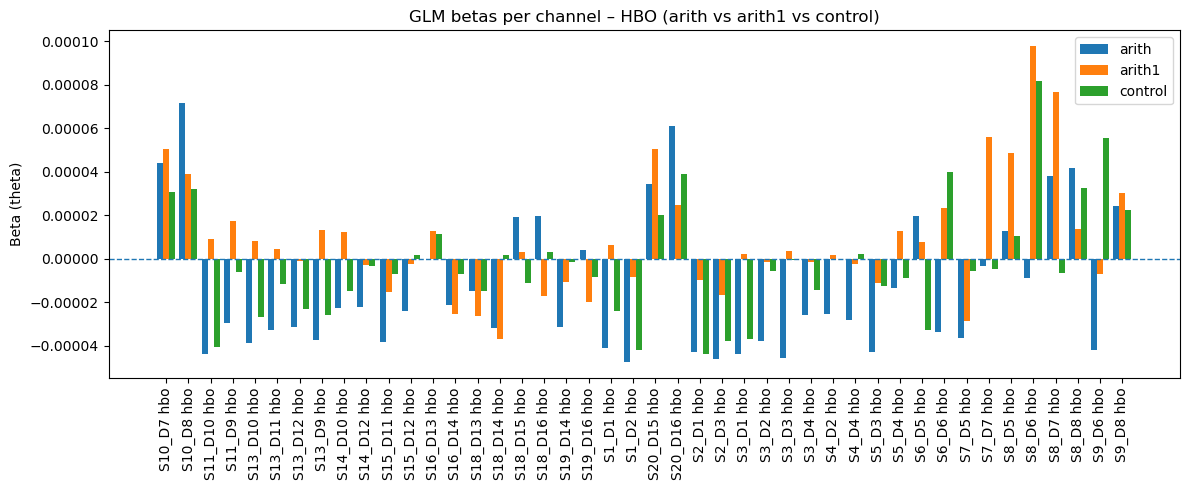

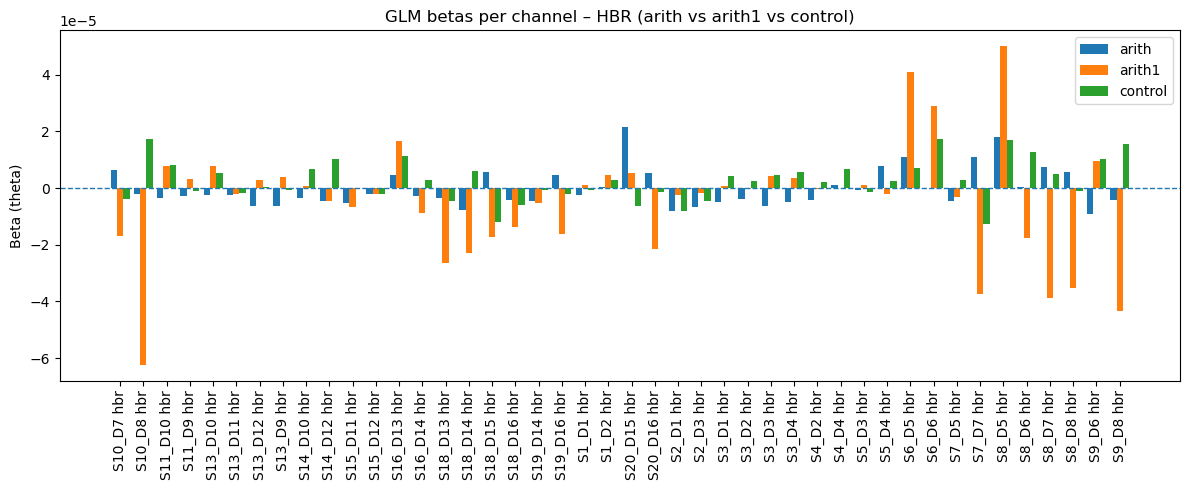


Creating heatmap of HbO betas (arith/arith1/control)...


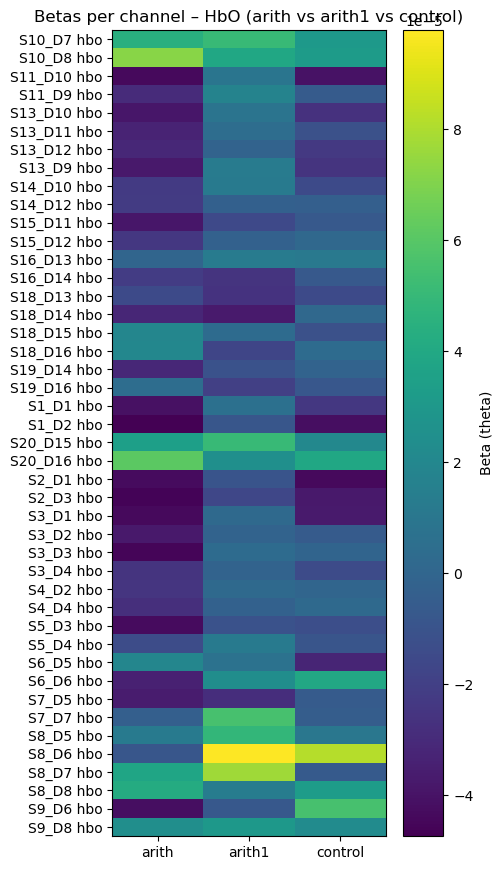


Creating volcano-style scatter for 'arith' and 'arith1'...


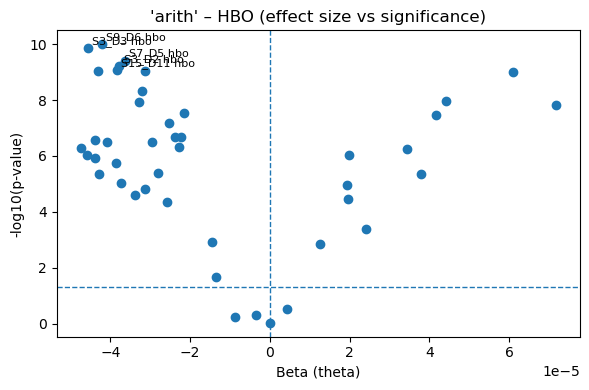

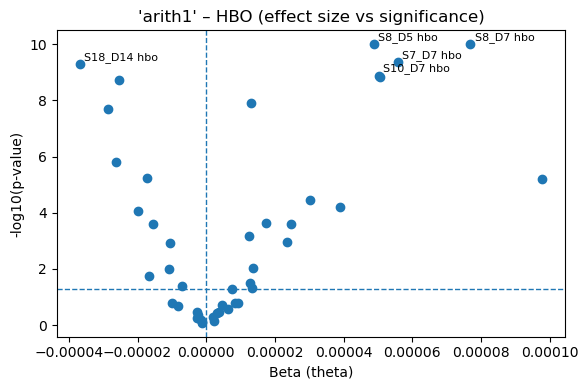

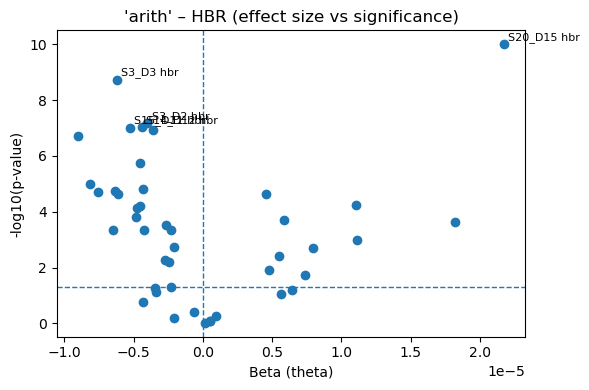

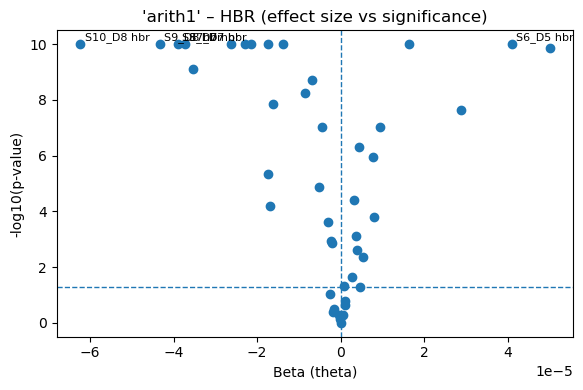


Done. Figures have been displayed.


In [79]:
# plot_glm_from_csv.py
#
# Read MNE-NIRS GLM results saved with RegressionResults.to_dataframe()
# and generate plots.
#
# Expected CSV columns:
#   Condition, Chroma, ch_name, theta, p_value, ...

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 0) INPUTS
# -----------------------------
out_csv = "/Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/snirf_files_with_correct_stim_events_BNDY/preproc_for_mne/mne_derived/mne_derived/subject_level_glm_mne.csv"
CSV_PATH = Path(out_csv)


ALPHA = 0.05  # p-value threshold

conditions_of_interest = ["arith", "arith1", "control"]

# -----------------------------
# 1) LOAD DATA
# -----------------------------
print(f"Loading GLM results from: {CSV_PATH}")
df = pd.read_csv(CSV_PATH)

print("\nColumns in file:")
print(df.columns.tolist())

required_cols = {"Condition", "Chroma", "ch_name", "theta", "p_value"}
missing = required_cols.difference(df.columns)
if missing:
    raise RuntimeError(f"CSV is missing columns: {missing}")

# Force string columns to string (prevents weird comparisons)
df["Condition"] = df["Condition"].astype(str).str.strip()
df["Chroma"] = df["Chroma"].astype(str).str.strip().str.lower()
df["ch_name"] = df["ch_name"].astype(str).str.strip()

print("\nUnique conditions in CSV:")
print(sorted(df["Condition"].unique().tolist()))
print("\nUnique chroma in CSV:")
print(sorted(df["Chroma"].unique().tolist()))

# -----------------------------
# 2) SUMMARY: SIGNIFICANT CHANNELS
# -----------------------------
sig = df[df["p_value"] < ALPHA]
summary = (
    sig.groupby(["Condition", "Chroma"])["ch_name"]
       .nunique()
       .reset_index(name="n_sig_channels")
)
print(f"\nNumber of significant channels (p < {ALPHA:.3f}) per condition & chroma:")
print(summary.to_string(index=False))

# -----------------------------
# Helper
# -----------------------------
def _order_channels(sub_df: pd.DataFrame) -> pd.DataFrame:
    """Sort by channel name and set ch_name as index (keeps 1 row per ch_name if already unique)."""
    return sub_df.sort_values("ch_name").set_index("ch_name")

# -----------------------------
# 3) BAR PLOTS: BETAS PER CHANNEL (ARITH vs ARITH1 vs CONTROL)
# -----------------------------
print("\nCreating grouped bar plots for 'arith', 'arith1', and 'control' betas per channel...")

chroma_list = sorted(df["Chroma"].unique())
for chroma in chroma_list:
    df_ch = df[(df["Chroma"] == chroma) & (df["Condition"].isin(conditions_of_interest))]

    if df_ch.empty:
        print(f"  - Skipping chroma '{chroma}': no rows for the selected conditions.")
        continue

    df_arith  = _order_channels(df_ch[df_ch["Condition"] == "arith"])
    df_arith1 = _order_channels(df_ch[df_ch["Condition"] == "arith1"])
    df_ctrl   = _order_channels(df_ch[df_ch["Condition"] == "control"])

    # Require all 3 to compare apples-to-apples
    if df_arith.empty or df_arith1.empty or df_ctrl.empty:
        print(f"  - Skipping chroma '{chroma}': missing one of arith/arith1/control.")
        continue

    # Align by common channels present in all three
    common_channels = df_arith.index.intersection(df_arith1.index).intersection(df_ctrl.index)
    if len(common_channels) == 0:
        print(f"  - Skipping chroma '{chroma}': no common channels across all 3 conditions.")
        continue

    df_arith  = df_arith.loc[common_channels]
    df_arith1 = df_arith1.loc[common_channels]
    df_ctrl   = df_ctrl.loc[common_channels]

    x = np.arange(len(common_channels))
    width = 0.27  # 3 bars -> narrower width

    fig, ax = plt.subplots(figsize=(12, 5))
    ax.bar(x - width, df_arith["theta"],  width, label="arith")
    ax.bar(x,         df_arith1["theta"], width, label="arith1")
    ax.bar(x + width, df_ctrl["theta"],   width, label="control")

    ax.axhline(0.0, linestyle="--", linewidth=1)
    ax.set_xticks(x)
    ax.set_xticklabels(common_channels, rotation=90)
    ax.set_ylabel("Beta (theta)")
    ax.set_title(f"GLM betas per channel – {chroma.upper()} (arith vs arith1 vs control)")
    ax.legend()
    fig.tight_layout()
    plt.show()

# -----------------------------
# 4) HEATMAP: HbO BETAS (ARITH/ARITH1/CONTROL)
# -----------------------------
print("\nCreating heatmap of HbO betas (arith/arith1/control)...")

if "hbo" in df["Chroma"].unique():
    df_hbo = df[(df["Chroma"] == "hbo") & (df["Condition"].isin(conditions_of_interest))]
    if not df_hbo.empty:
        heat = df_hbo.pivot(index="ch_name", columns="Condition", values="theta")

        # Keep columns in your desired order (if present)
        cols_present = [c for c in conditions_of_interest if c in heat.columns]
        heat = heat[cols_present].sort_index()

        fig, ax = plt.subplots(figsize=(5, max(4, len(heat) * 0.2)))
        im = ax.imshow(heat.values, aspect="auto")

        ax.set_xticks(np.arange(heat.shape[1]))
        ax.set_xticklabels(heat.columns)
        ax.set_yticks(np.arange(heat.shape[0]))
        ax.set_yticklabels(heat.index)

        ax.set_title("Betas per channel – HbO (arith vs arith1 vs control)")
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label("Beta (theta)")

        fig.tight_layout()
        plt.show()
    else:
        print("No HbO rows for arith/arith1/control found in CSV.")
else:
    print("No HbO data in CSV – skipping heatmap.")

# -----------------------------
# 5) VOLCANO PLOTS: ARITH and ARITH1 (BETA vs -log10(p))
# -----------------------------
print("\nCreating volcano-style scatter for 'arith' and 'arith1'...")

for chroma in chroma_list:
    for cond in ["arith", "arith1"]:
        df_cond = df[(df["Condition"] == cond) & (df["Chroma"] == chroma)]
        if df_cond.empty:
            continue

        p = df_cond["p_value"].clip(lower=1e-10)
        neg_log_p = -np.log10(p)

        fig, ax = plt.subplots(figsize=(6, 4))
        ax.scatter(df_cond["theta"], neg_log_p)

        ax.axvline(0.0, linestyle="--", linewidth=1)
        ax.axhline(-np.log10(ALPHA), linestyle="--", linewidth=1)

        ax.set_xlabel("Beta (theta)")
        ax.set_ylabel("-log10(p-value)")
        ax.set_title(f"'{cond}' – {chroma.upper()} (effect size vs significance)")

        # Label top 5 most significant
        top = df_cond.assign(neg_log_p=neg_log_p).nlargest(5, "neg_log_p")
        for _, row in top.iterrows():
            ax.annotate(
                row["ch_name"],
                (row["theta"], -np.log10(max(row["p_value"], 1e-10))),
                xytext=(3, 3),
                textcoords="offset points",
                fontsize=8,
            )

        fig.tight_layout()
        plt.show()

print("\nDone. Figures have been displayed.")


In [78]:
# glm_subject_from_runs.py
from pathlib import Path
import numpy as np
import pandas as pd
import mne

from mne.preprocessing.nirs import optical_density, beer_lambert_law
from mne_nirs.channels import get_long_channels
from mne_nirs.experimental_design import make_first_level_design_matrix
from mne_nirs.statistics import run_glm


# -----------------------------
# Helpers
# -----------------------------
def _drop_bad_annotations(raw: mne.io.BaseRaw) -> mne.io.BaseRaw:
    """Remove boundary/bad annotations so they don't become regressors."""
    ann = raw.annotations
    if ann is None or len(ann) == 0:
        return raw
    keep = [not str(d).upper().startswith("BAD") for d in ann.description]
    raw.set_annotations(ann[keep])
    return raw


def _infer_stim_dur(raw: mne.io.BaseRaw, fallback: float = 5.0) -> float:
    """Pick a reasonable block duration from annotations."""
    if raw.annotations is None or len(raw.annotations) == 0:
        return fallback
    durs = np.asarray(raw.annotations.duration, dtype=float)
    durs = durs[np.isfinite(durs) & (durs > 0)]
    return float(np.median(durs)) if len(durs) else fallback


def load_prepare_run(snirf_path: Path) -> mne.io.BaseRaw:
    """
    Load one run SNIRF, ensure HbO/HbR, keep long channels, clean annotations.
    """
    raw = mne.io.read_raw_snirf(snirf_path, preload=True)
    raw = _drop_bad_annotations(raw)

    ch_types = raw.get_channel_types(unique=True)

    if "fnirs_cw_amplitude" in ch_types:
        raw_od = optical_density(raw)
        raw_hb = beer_lambert_law(raw_od)
    elif any(ct in ("hbo", "hbr") for ct in ch_types):
        raw_hb = raw.copy()
    else:
        raise RuntimeError(
            f"{snirf_path.name}: Unexpected channel types {ch_types}. "
            "Expected 'fnirs_cw_amplitude' or 'hbo'/'hbr'."
        )

    raw_hb = get_long_channels(raw_hb)
    raw_hb = _drop_bad_annotations(raw_hb)  # again after transforms (safe)
    return raw_hb


def build_subject_design_matrix_from_run_dms(
    run_dms: list[pd.DataFrame],
    run_n_times: list[int],
    sfreq: float,
) -> pd.DataFrame:

    def split_cols(dm: pd.DataFrame):
        nuisance = [c for c in dm.columns if (c == "constant" or str(c).startswith("drift"))]
        cond = [c for c in dm.columns if c not in nuisance]
        return cond, nuisance

    # Union of all condition columns across runs (shared effects)
    cond_union = []
    for dm in run_dms:
        cond_cols, _ = split_cols(dm)
        for c in cond_cols:
            if c not in cond_union:
                cond_union.append(c)

    offset = 0
    dm_blocks = []

    for i, dm in enumerate(run_dms, start=1):
        dm = dm.copy()

        # Sanity check: DM rows should match data samples for that run
        if dm.shape[0] != run_n_times[i - 1]:
            raise RuntimeError(
                f"Run {i}: design matrix rows ({dm.shape[0]}) != raw.n_times ({run_n_times[i-1]})."
            )

        # Ensure all shared condition columns exist in this run
        for c in cond_union:
            if c not in dm.columns:
                dm[c] = 0.0

        cond_cols, nuisance_cols = split_cols(dm)

        # Rename nuisance columns to be run-specific
        rename_map = {c: f"{c}_run{i}" for c in nuisance_cols}
        dm = dm.rename(columns=rename_map)

        # Keep columns in a consistent order
        dm = dm[cond_union + [rename_map[c] for c in nuisance_cols]]

        # IMPORTANT: use sample index directly (0..n_times-1), then offset
        dm.index = np.arange(run_n_times[i - 1]) + offset
        offset += run_n_times[i - 1]

        dm_blocks.append(dm)

    total_n = int(sum(run_n_times))

    # Stack runs in time; missing columns become NaN -> we fix that
    dm_subject = pd.concat(dm_blocks, axis=0, sort=False).sort_index()

    # Ensure every sample exists (0..total_n-1)
    dm_subject = dm_subject.reindex(np.arange(total_n), fill_value=0.0)

    # convert NaNs (from “columns absent in that run”) into zeros
    dm_subject = dm_subject.fillna(0.0).astype(float)

    # index in seconds (nice for plotting)
    dm_subject.index = dm_subject.index / sfreq

    return dm_subject



# -----------------------------
# MAIN
# -----------------------------
# 1) List all run files for this subject

path_str = "/Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/snirf_files_with_correct_stim_events_BNDY/preproc_for_mne/mne_derived"
runs_dir = Path("/Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/snirf_files_with_correct_stim_events_BNDY/preproc_for_mne/mne_derived")

run_paths = sorted(runs_dir.glob("*.snirf"))

print("Found runs:")
for p in run_paths:
    print(p)

out_csv = runs_dir / "mne_derived" / "subject_level_glm_mne.csv"
out_csv.parent.mkdir(exist_ok=True)
print(out_csv)


# 2) Load + prep each run
raw_runs = [load_prepare_run(p) for p in run_paths]

# 3) Make sure channel sets match across runs (use common channels, keep same order)
common = set(raw_runs[0].ch_names)
for r in raw_runs[1:]:
    common &= set(r.ch_names)

if len(common) == 0:
    raise RuntimeError("No common channels across runs after long-channel selection.")

common_order = [ch for ch in raw_runs[0].ch_names if ch in common]
raw_runs = [r.copy().pick_channels(common_order) for r in raw_runs]

# 4) Check sampling frequency is consistent
sfreqs = [r.info["sfreq"] for r in raw_runs]
if not np.allclose(sfreqs, sfreqs[0]):
    raise RuntimeError(f"Different sampling rates across runs: {sfreqs}. Resample to match first.")
sfreq = float(sfreqs[0])

# 5) Build run-level design matrices (one per run)
run_dms = []
run_n_times = []

for raw in raw_runs:
    stim_dur = _infer_stim_dur(raw, fallback=5.0)

    dm = make_first_level_design_matrix(
    raw,
    stim_dur=stim_dur,
    hrf_model="glover"    # canonical HRF, like SPM
    )
    
    dm = make_first_level_design_matrix(
        raw,
        stim_dur=stim_dur,
        hrf_model="glover",
        drift_model="cosine",
        high_pass=0.01,   # adjust per your task if needed
    )
    run_dms.append(dm)
    run_n_times.append(raw.n_times)

# 6) Concatenate raws (subject/session time series)
raw_all = mne.concatenate_raws([r.copy() for r in raw_runs], preload=True)

# 7) Build subject-level design matrix FROM the run-level design matrices
dm_subject = build_subject_design_matrix_from_run_dms(run_dms, run_n_times, sfreq)

print("Subject-level design matrix columns:")
print(list(dm_subject.columns))
print(dm_subject.head())

n_nans = int(dm_subject.isna().sum().sum())
print("NaNs in design matrix:", n_nans)


# 8) Fit GLM on concatenated data
glm_est = run_glm(raw_all, dm_subject)

# 9) Export
df = glm_est.to_dataframe()
df.to_csv(out_csv, index=False)
print(f"Saved subject-level GLM results to: {out_csv}")


Found runs:
/Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/snirf_files_with_correct_stim_events_BNDY/preproc_for_mne/mne_derived/sub-bndy_ses-tp1_task-arith_run-1_nirs_with_events_preproc_hb_mne_clean.snirf
/Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/snirf_files_with_correct_stim_events_BNDY/preproc_for_mne/mne_derived/sub-bndy_ses-tp1_task-arith_run-2_nirs_with_events_preproc_hb_mne_clean.snirf
/Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/snirf_files_with_correct_stim_events_BNDY/preproc_for_mne/mne_derived/sub-bndy_ses-tp1_task-arith_run-3_nirs_with_events_preproc_hb_mne_clean.snirf
/Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/snirf_files_with_correct_stim_events_BNDY/preproc_for_mne/mne_derived/sub-bndy_ses-tp1_task-arith_ru

In [59]:
path_str = "/Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/snirf_files_with_correct_stim_events_BNDY"
runs_dir = Path("/Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/snirf_files_with_correct_stim_events_BNDY")

run_paths = sorted(runs_dir.glob("*.snirf"))

print("Found runs:")
for p in run_paths:
    print(p)

out_csv = runs_dir / "mne_derived" / "subject_level_glm_mne.csv"
out_csv.parent.mkdir(exist_ok=True)
print(run_paths)

Found runs:
/Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/snirf_files_with_correct_stim_events_BNDY/sub-bndy_ses-tp1_task-arith_run-1_nirs_with_events.snirf
/Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/snirf_files_with_correct_stim_events_BNDY/sub-bndy_ses-tp1_task-arith_run-2_nirs_with_events.snirf
/Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/snirf_files_with_correct_stim_events_BNDY/sub-bndy_ses-tp1_task-arith_run-3_nirs_with_events.snirf
/Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/snirf_files_with_correct_stim_events_BNDY/sub-bndy_ses-tp1_task-arith_run-4_nirs_with_events.snirf
[PosixPath('/Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/snirf_files_with_correct_